আগে সব আনি
---

In [1]:
import numpy as np
from IPython.display import display, Image
import os
import PIL.Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("training-a.csv")

In [3]:
df.head()

,filename,original filename,scanid,digit,database name original,contributing team,database name
0,a00000.png,Scan_58_digit_5_num_8.png,58,5,BHDDB,Buet_Broncos,training-a
1,a00001.png,Scan_73_digit_3_num_5.png,73,3,BHDDB,Buet_Broncos,training-a
2,a00002.png,Scan_18_digit_1_num_3.png,18,1,BHDDB,Buet_Broncos,training-a
3,a00003.png,Scan_166_digit_7_num_3.png,166,7,BHDDB,Buet_Broncos,training-a
4,a00004.png,Scan_108_digit_0_num_1.png,108,0,BHDDB,Buet_Broncos,training-a


In [4]:
df['digit'][0:5]

0    5
1    3
2    1
3    7
4    0
Name: digit, dtype: int64

In [5]:
mydict = dict(zip(df.filename, df.digit))

In [6]:
x=0
for k in mydict: 
    print(k,":",mydict[k])
    x+=1
    if x==10:
        break

a12436.png : 0
a05619.png : 1
a08112.png : 8
a17495.png : 8
a00414.png : 4
a18329.png : 5
a17341.png : 5
a11354.png : 4
a11177.png : 8
a10913.png : 2


একটা খুলে দেখি ।
--

In [7]:
filenames = list(mydict.keys())

(28, 28)

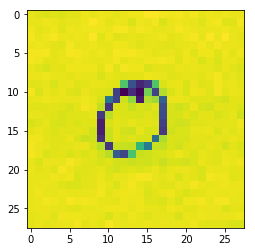

In [8]:
fname = filenames[0]
image = cv2.imread("training-a/"+fname)
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image = cv2.resize(image,(28,28))
plt.imshow(image)
image.shape

In [9]:
%%time
x = []
y = []
for fname in mydict : 
    img = cv2.imread("training-a/"+fname)
    if img is not None:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img,(28,28),interpolation = cv2.INTER_CUBIC)
        img = np.array(img)
        x.append(img)
        y.append(mydict[fname])
print(len(x),len(y))

19701 19701
Wall time: 7min 53s


In [10]:
x = np.array(x)
x.shape

(19701, 28, 28)

কয়েকটা ছবি দেখা যাক
---

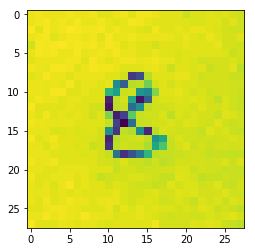

4


In [11]:
import random
import matplotlib.pyplot as plt

ind = random.randint(0,len(x))
plt.imshow(x[ind])
plt.show()
print(y[ind])

এবার scikit দিয়ে একটু দেখা যাক 
---

In [12]:
%%time
ex = []
for i in x:
    ex.append(np.ndarray.flatten(i))
ex = np.array(ex)
print(ex.shape)

(19701, 784)
Wall time: 56.5 ms


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ex, y, test_size=0.20, random_state=42)

In [14]:
print(len(X_train),len(y_train))

15760 15760


In [15]:
print(len(X_test),len(y_test))

3941 3941


In [17]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
prediction = clf.predict(X_test)
accscore = accuracy_score(y_test,prediction)
print(accscore)

0.5211875158589191


Let's Go For Keras!
--
Building Model : 

In [18]:
from keras.utils import np_utils
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

c:\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [22]:
nb_classes=10
y_train = np.array(y_train)
y_train = np_utils.to_categorical(y_train, nb_classes).astype(np.float32)
class_totals = y_train.sum(axis=0)
class_weight = class_totals.max() / class_totals
y_train.shape

(15760, 10)

In [23]:
X_train=X_train.reshape(15760,28,28,1)
X_train.shape

(15760, 28, 28, 1)

In [25]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = X_train.shape[1:]))
model.add(Conv2D(filters = 32, kernel_size = (4,4),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [27]:
validation_split = 0.10
model.fit(X_train, y_train, batch_size=1000, class_weight=class_weight, epochs=20, verbose=1, validation_split=validation_split)

Train on 14184 samples, validate on 1576 samples
Epoch 1/20
14184/14184 [==============================] - 3s 224us/step - loss: 0.7704 - acc: 0.7389 - val_loss: 0.5705 - val_acc: 0.8141
Epoch 2/20
14184/14184 [==============================] - 3s 208us/step - loss: 0.6888 - acc: 0.7618 - val_loss: 0.5295 - val_acc: 0.8280
Epoch 3/20
14184/14184 [==============================] - 3s 209us/step - loss: 0.6292 - acc: 0.7877 - val_loss: 0.6655 - val_acc: 0.7716
Epoch 4/20
14184/14184 [==============================] - 3s 209us/step - loss: 0.6158 - acc: 0.7881 - val_loss: 0.4428 - val_acc: 0.8566
Epoch 5/20
14184/14184 [==============================] - 3s 212us/step - loss: 0.5331 - acc: 0.8182 - val_loss: 0.5648 - val_acc: 0.8312
Epoch 6/20
14184/14184 [==============================] - 3s 210us/step - loss: 0.4966 - acc: 0.8320 - val_loss: 0.3485 - val_acc: 0.8788
Epoch 7/20
14184/14184 [==============================] - 3s 209us/step - loss: 0.5043 - acc: 0.8289 - val_loss: 0.3519 - v

In [28]:
open('model.json', 'w').write(model.to_json())
model.save_weights('weights.h5')
print("Model Saved")

Model Saved


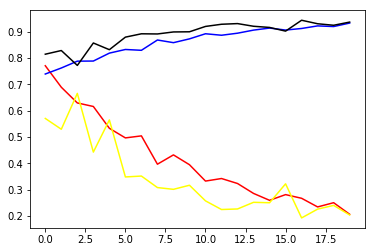

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(model.model.history.history['loss'],'red')
plt.plot(model.model.history.history['acc'],'blue')
plt.plot(model.model.history.history['val_loss'],'yellow')
plt.plot(model.model.history.history['val_acc'],'black')
plt.show()

Testing out our Model!
---

In [30]:
X_test = X_test.reshape(3941,28,28,1)
pred = model.predict(X_test)

In [32]:
X_test = X_test.reshape(3941,28,28)

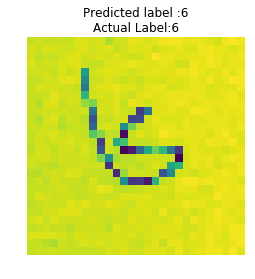

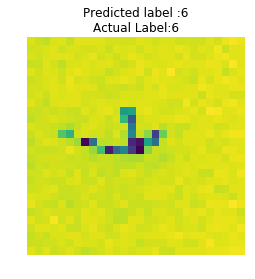

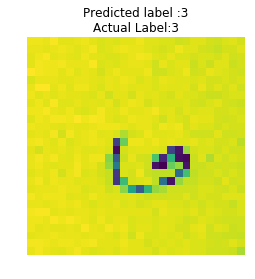

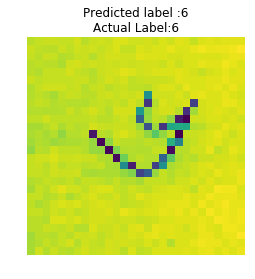

In [53]:
m = 4
for i in range(m):
    ids = random.randint(0,3941)
    #print
    predicted = pred[ids]
    actual = y_test[ids]
    #show
    plt.imshow(X_test[ids])
    plt.title("Predicted label :"+str(np.argmax(predicted))+"\nActual Label:"+str(actual))
    plt.axis('off')
    plt.show()

Let's see our testing accuracy!
---

In [51]:
p = np.argmax(pred,axis=1)
accscore = accuracy_score(y_test,p)
print(accscore)

0.9413854351687388


Thus we see that with a Convolutional Neural Net optimized with RMSProp and LearningRateReduction we can achieve a ~94% accuracy on the testset for Bengali Digit Recognition.